# PySCF - Getting electron densities with PySCF

## Introduction

PySCF is an open source Python library targetting QM calculations. It has a reachable API that allows the user to work with some of the inner aspects of the calculations (on the contrary, many other QM methods work as black boxes for the user).

We will use PySCF to obtain:
1. Raw electron densities
2. Cube files
3. WFN files
4. Density Fittings
5. Integrating properties

## Running a typical calculation

In this case we will use a standard DFT calculation. Post-HF methods can also be obtained through PySCF. Yet, they might require some handling of the post-HF wave-function, which contains non-empty virtual orbitals.

In [1]:
import numpy as np
from pyscf import gto, dft
from pyscf.dft import numint
from pyscf.dft import r_numint

PySCF requires defining the basis set for a given molecule, and then performing the QM calculation on top of that basis.

In [2]:
# Standard calcualtion
mol = gto.M(
    verbose = 0,
    atom = '''
    o    0    0.       0.
    h    0    -0.757   0.587
    h    0    0.757    0.587''',
    basis = 'ccpvtz'
) # GTO -> Gaussian Type Orbitals

mf = dft.RKS(mol)
mf.xc = 'scan' # Other functionals can be used: wb97x, b3lyp, m06, ...
mf.kernel() # This returns the energy

-76.42589425695505

## Getting the electron density

For this, we require to compute the one-body density matrix, which is computed as:


$$ D_{\mu\eta}= \sum_{i}^{norb} n_{i} c_{i,\mu} c_{i, \eta} $$

Where $n$ represents the occupancy number of each orbital, and $c_{ij}$ the coefficient associated to basis primitive function $j$ in orbital $i$.

PySCF already contains a subrutine that makes this easier to us.

In [3]:
dm = mf.make_rdm1()

The next step consists on calculating the values of the electron density. 

$$ \rho(r) = \sum_{\mu}^{nprim} \sum_{\eta}^{nprim} D_{\mu\eta} \chi_{\mu}(r) \chi_{\eta}(r) $$

We can employ their numerical tool eval_rho, or we can calculate it ourselves. Yet, the first approach will allow us to access to the gradients of the electron density, whose density is not trivial to compute due to the two-center analytical shape. 

In this exercise, we will calculate it for the atomic coordinates.

In [4]:
# Calulate atomic orbitals upon coordinates
ao_value = numint.eval_ao(mol, mol.atom_coords(), deriv=1)
# Calculate electron density + derivatives
rho = numint.eval_rho(mol, ao_value, dm, xctype='GGA')
rho[0]

array([297.86350681,   0.41830389,   0.41830389])

**Proposed Exercise**: Depict the electron density for:
- the water molecule plane (using the same coordinates above)
- the benzene molecule (use coordinates from file examples/benzene.xyz)
- the bond between ethane carbons (use coordinates from file examples/ethane.xyz)

**Tip**: For the first two quests, you can use the matplotlib function contourf. You might requrire to generate a mesh grid. 


### Exercise 1, Solution

In [5]:
import matplotlib.pyplot as plt
import numpy as np


In [6]:
def density(mol, mf, x):
    
    dm = mf.make_rdm1()
    ao = numint.eval_ao(mol, x, deriv=0)
    rho = numint.eval_rho(mol, ao, dm)
    return rho

In [7]:
mol = gto.Mole()
mol.atom = 'examples/benzene.xyz'
mol.basis = 'cc-pvtz'
mol.build()

mf = dft.RKS(mol)
mf.xc = 'b3lyp' # Other functionals can be used: wb97x, b3lyp, m06, ...
mf.kernel()

converged SCF energy = -232.178998019898


-232.17899801989842

In [9]:
min_x = mol.atom_coords().min(0)[0]
max_x = mol.atom_coords().max(0)[0]
min_y = mol.atom_coords().min(0)[1]
max_y = mol.atom_coords().max(0)[1]
z = mol.atom_coords().max(0)[2]

xx = np.arange(min_x - 2.0, max_x + 2.0, 0.1)
yy = np.arange(min_y - 2.0, max_y + 2.0, 0.1)
X, Y = np.meshgrid(xx, yy)
R = np.stack([X.flatten(), Y.flatten(), z * np.ones_like(Y.flatten())], axis=1)
P = density(mol, mf, R).reshape(yy.size, xx.size)

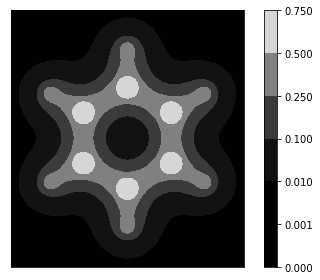

In [10]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
cb = ax.contourf(X, Y, P.clip(min=0, max=0.75), levels=[0.0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75], cmap='gray')
plt.colorbar(cb)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.savefig('./examples/benzene.density.png', dpi=300)
plt.show()

converged SCF energy = -79.7991399779774
converged SCF energy = -78.5649572381082
converged SCF energy = -77.3123436078042


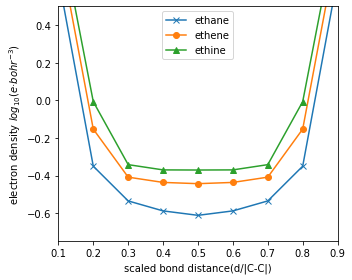

In [11]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 4)
mol_name_dict = dict(ethane='x', ethene='o', ethine='^')

for mol_name, symbol in mol_name_dict.items():

    mol = gto.Mole()
    mol.atom = 'examples/{:s}.xyz'.format(mol_name)
    mol.basis = 'cc-pvtz'
    mol.build()
    mf = dft.RKS(mol)
    mf.xc = 'b3lyp' # Other functionals can be used: wb97x, b3lyp, m06, ...
    mf.kernel()
    c1 = mol.atom_coords()[0, :]
    c2 = mol.atom_coords()[1, :]
    d = c2 - c1
    d = d / 10
    r = c1 + np.arange(11).reshape(-1, 1) * d
    p = density(mol, mf, r)
    ax.plot(np.arange(11) / 10, np.log10(p), label=mol_name, marker=symbol)
    
ax.legend()
ax.set_ylim(-0.75, 0.5)
ax.set_xlim(0.1, 0.9)
ax.set_xlabel('scaled bond distance(d/|C-C|)')
ax.set_ylabel('electron density $log_{10} ( e·bohr^{-3} ) $')
fig.tight_layout()
plt.savefig('./examples/cc_bond.density.png', dpi=300)
plt.show()

## Cube files

Cube files allow the visualization of electron density using specific visualization programs. In this tutorial, we will consider the use of ChimeraX. But others can be employed. A rather chemistry-focused tool might be Avogadro.

We will use the default cube writting tool from PySCF.

In [12]:
from pyscf.tools import cubegen

mol = gto.Mole()
mol.atom = 'examples/benzene.xyz'
mol.basis = 'cc-pvtz'
mol.build()
mf = dft.RKS(mol)
mf.xc = 'b3lyp' # Other functionals can be used: wb97x, b3lyp, m06, ...
mf.kernel()
dm = mf.make_rdm1()

cb = cubegen.density(mol, 'benzene.cube', dm)

converged SCF energy = -232.178998019898


ChimeraX can be downloaded from its webpage at XXX. Its use is rather straight-forward, but we include a snapshoot to illustrate how to visualize electron densities.

![](Practical1.png)

## WFN files

It is likely that we want our resulting electron density to be analyzed by some other code (e.g., Horton). For that, the WFN format is a well-known one (though a little bit old-fashioned). We will use the WFN writing utility from PySCF.

In [13]:
from pyscf.tools import wfn_format

In [14]:
coeff = mf.mo_coeff[:,mf.mo_occ>0]
energy = mf.mo_energy[mf.mo_occ>0]
occ = mf.mo_occ[mf.mo_occ>0]
with open('benzene_dft.wfn', 'w') as f2:
    wfn_format.write_mo(f2, mol, coeff, energy, occ)

## Integration

PySCF provides DFT integration grids, which are obtained from overlapping spheres and a tesellation scheme. We can employ such grids to compute electron density properties.

In [15]:
g = dft.gen_grid.Grids(mol)
g.level=1
g.build()

We shall compute the normalization of the electron density

In [16]:
ao_value = numint.eval_ao(mol, g.coords)
rho = numint.eval_rho(mol, ao_value, dm)

n = (rho * g.weights).sum()
print(n) # This should be very close to 10

41.99995361422252


**Proposed Exercises**: Compute, using the integration grids:
- electron density dipole of the water molecule
- the electrostatic potential at nuclei positions
- the Dirac exchange

From the df_coef, we can obtain the linear expansion, and compute electron densities.

## Density Fitting

Two center electron density is expensive to compute, and the calculation of some integrals can become burdensome. A way to reduce the computational complexity is to replace the two body expansion by a linear expansion.

$$ \rho(r) = \sum_{i}^{aux} c^{aux}_{i} \chi^{aux}_{i}(r) $$

Some basis sets have auxilary basis sets taylored to become equivalent after decomposition. For each auxilary basis set and QM calculation, it is necessary to compute the coefficients of the linear expansion. We can do so by projecting the potential generated by the product of two centers and once center functions into the two center 


In [17]:
from pyscf import df
import scipy

In [18]:
# Definining a reduced matrix

auxmol = df.addons.make_auxmol(mol, 'ccpvdz-jk-fit')

# Calculating integrals between mol and auxmol

ints_3c2e = df.incore.aux_e2(mol, auxmol, intor='int3c2e')
ints_2c2e = auxmol.intor('int2c2e')

# Number of orbitals

nao = mol.nao
naux = auxmol.nao

# Solve the density tensor

df_coef = scipy.linalg.solve(ints_2c2e, ints_3c2e.reshape(nao*nao, naux).T)
df_coef = df_coef.reshape(naux, nao, nao)

In [19]:
dm_ = dm.reshape(1, nao, nao)
c = (dm_ * df_coef).sum((1, 2)) 


chi_aux = numint.eval_ao(auxmol, g.coords)
rho = (c.reshape(1, naux) * chi_aux).sum(1)


The integral of the density here should be also around 42 + integration error.

In [20]:
(rho * g.weights).sum()

41.99980273580332